In [1]:
# Import necessary libraries: pandas, numpy, matplotlib, and yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

# Step 1: Load the data
# Load the data from yfinance into a pandas DataFrame

tick = yf.Ticker("SPY")
end_date = datetime.now().strftime('%Y-%m-%d')
data = tick.history(start='2022-01-01',end=end_date)

lt_window = 120
st_window = 40

# Preview the data to ensure it's loaded correctly!
print(data.head())

                                 Open        High         Low       Close  \
Date                                                                        
2022-01-03 00:00:00-05:00  455.832137  457.315547  453.487437  457.181549   
2022-01-04 00:00:00-05:00  458.626660  459.354011  455.143067  457.028412   
2022-01-05 00:00:00-05:00  456.655202  457.439971  448.156794  448.252502   
2022-01-06 00:00:00-05:00  447.783581  450.587665  445.429273  447.831421   
2022-01-07 00:00:00-05:00  447.841030  449.037314  444.682822  446.060944   

                              Volume  Dividends  Stock Splits  Capital Gains  
Date                                                                          
2022-01-03 00:00:00-05:00   72668200        0.0           0.0            0.0  
2022-01-04 00:00:00-05:00   71178700        0.0           0.0            0.0  
2022-01-05 00:00:00-05:00  104538900        0.0           0.0            0.0  
2022-01-06 00:00:00-05:00   86858900        0.0           0.0    

In [2]:

# Step 2: Data Cleaning
# Check for missing values in the DataFrame
data.ffill
data['null_count'] = data.isna().sum(axis=1)

# Fill In Missing Values:
data.fillna('NaN')



,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains,null_count
Date,,,,,,,,,
2022-01-03 00:00:00-05:00,455.832137,457.315547,453.487437,457.181549,72668200,0.000,0.0,0.0,0
2022-01-04 00:00:00-05:00,458.626660,459.354011,455.143067,457.028412,71178700,0.000,0.0,0.0,0
2022-01-05 00:00:00-05:00,456.655202,457.439971,448.156794,448.252502,104538900,0.000,0.0,0.0,0
2022-01-06 00:00:00-05:00,447.783581,450.587665,445.429273,447.831421,86858900,0.000,0.0,0.0,0
2022-01-07 00:00:00-05:00,447.841030,449.037314,444.682822,446.060944,85111600,0.000,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
2024-12-16 00:00:00-05:00,603.967249,605.741308,603.179921,604.754578,43695200,0.000,0.0,0.0,0
2024-12-17 00:00:00-05:00,602.163299,603.139992,600.867672,602.262939,55773500,0.000,0.0,0.0,0
2024-12-18 00:00:00-05:00,601.953994,604.375836,583.924709,584.313416,108248700,0.000,0.0,0.0,0


In [3]:

# Step 3: Strategy: Linear Regression indicator

def calculate_linreg(data, window, linreg_column):
#make a placeholder values list that gets updated
#this has window # of 0s because the regression is incomplete on values prior to the window as there are not enough to compute
  values_list = [0] * window
# a placeholder point value that gets appended to valuelist as teh loop runs
  point = 0.0000
  # Calculate the linear regression for the specified window
  #each row needs to pull the last window number of prices and create a new dataframe
  for current_row in range(window, len(data)):
    if current_row < window:
      point = 0
    else:
      #making the dataframe with all the parameters required
      lindata = pd.DataFrame({'price': data['Close'].iloc[current_row - window:current_row].values})
      lindata['index'] = range(1, window+1)
      lindata['pricetime'] = lindata['price'] * lindata['index']
      lindata['sqindex'] = lindata['index'] ** 2
      #implementing the regression formlua for slope and intercept
      slope = (window * lindata['pricetime'].sum() - lindata['price'].sum() * lindata['index'].sum()) / (window * lindata['sqindex'].sum() - (lindata['index'].sum()) ** 2)
      intercept = (lindata['price'].sum() - slope * lindata['index'].sum())/window
      point = slope * (window) + intercept
    #adding the value to the list
    values_list.append(point)

    # this will put the linreg value at the given row
  data[linreg_column] = values_list
  return data
#get the linear regression values for different time frames
data = calculate_linreg(data, st_window, 'st_linreg')
data = calculate_linreg(data, lt_window, 'lt_linreg')

print(data.tail())



                                 Open        High         Low       Close  \
Date                                                                        
2024-12-16 00:00:00-05:00  603.967249  605.741308  603.179921  604.754578   
2024-12-17 00:00:00-05:00  602.163299  603.139992  600.867672  602.262939   
2024-12-18 00:00:00-05:00  601.953994  604.375836  583.924709  584.313416   
2024-12-19 00:00:00-05:00  589.376338  591.010851  583.884811  584.133972   
2024-12-20 00:00:00-05:00  581.770020  595.750000  580.909973  591.150024   

                              Volume  Dividends  Stock Splits  Capital Gains  \
Date                                                                           
2024-12-16 00:00:00-05:00   43695200      0.000           0.0            0.0   
2024-12-17 00:00:00-05:00   55773500      0.000           0.0            0.0   
2024-12-18 00:00:00-05:00  108248700      0.000           0.0            0.0   
2024-12-19 00:00:00-05:00   85919500      0.000           0.

In [4]:
# Step 4: signals
# now we must create signals for activity
# price>st_linreg, and lt_linreg(n)>lt_linreg(n-1), generate a buy signal
# lt_linreg(n)<lt_linreg(n-1) OR st_linreg(n)<stLlinreg(n-1), generate a sell signal
# otherwise hold the position, indicated by a 0
def generate_signals(data):
  signal_list = [0]
  inticator = 0

  for current_row in range(1, len(data)):
    if current_row < lt_window:
      indicator = 0
    else:
      #buy signal
      if data['Close'].iloc[current_row] > data['st_linreg'].iloc[current_row] and data['lt_linreg'].iloc[current_row] > data['lt_linreg'].iloc[current_row - 1]:
        indicator = 1
      #sell signal
      elif data['st_linreg'].iloc[current_row] < data['st_linreg'].iloc[current_row - 1] or data['lt_linreg'].iloc[current_row] < data['lt_linreg'].iloc[current_row - 1]:
        indicator = -1
      else:
        indicator = 0
    signal_list.append(indicator)
  data['pre-Signal'] = signal_list
  return data

data = generate_signals(data)

#for the purposes of this test, we care about the earliest signal that differs from the last, so we will eliminate duplicates.
# ex: 0, 1, 1, 1, 0, -1, -1, -1, 1 will become 0, 1, 0, 0, 0, -1, 0, 0, 1 since duplicate signals needlessly indicate an action
def preprocess_signals(data):
    data['Signal'] = 0
    # For every row, we check if the current signal differs from the previous one and add it in if it does
    for i in range(lt_window-st_window, len(data.index)):
      if data['pre-Signal'].iloc[i] != data['pre-Signal'].iloc[i-1]:
          data.loc[data.index[i], 'Signal'] = data.loc[data.index[i], 'pre-Signal']  # Assign the non-zero signal value
      else:
        data.loc[data.index[i], 'Signal'] = 0
    # going further, let's compare the last non-zero entry against the current non-zero entry, and if they match, set the current value to 0
    last_non_zero = 0
    for i in range(lt_window-st_window, len(data.index)):
      if data['Signal'].iloc[i] != 0:
        if data['Signal'].iloc[i] == last_non_zero:
          data.loc[data.index[i], 'Signal'] = 0
        else:
          last_non_zero = data.loc[data.index[i], 'Signal']
    return data

data = preprocess_signals(data)

print(data.tail())

                                 Open        High         Low       Close  \
Date                                                                        
2024-12-16 00:00:00-05:00  603.967249  605.741308  603.179921  604.754578   
2024-12-17 00:00:00-05:00  602.163299  603.139992  600.867672  602.262939   
2024-12-18 00:00:00-05:00  601.953994  604.375836  583.924709  584.313416   
2024-12-19 00:00:00-05:00  589.376338  591.010851  583.884811  584.133972   
2024-12-20 00:00:00-05:00  581.770020  595.750000  580.909973  591.150024   

                              Volume  Dividends  Stock Splits  Capital Gains  \
Date                                                                           
2024-12-16 00:00:00-05:00   43695200      0.000           0.0            0.0   
2024-12-17 00:00:00-05:00   55773500      0.000           0.0            0.0   
2024-12-18 00:00:00-05:00  108248700      0.000           0.0            0.0   
2024-12-19 00:00:00-05:00   85919500      0.000           0.

**For the future**

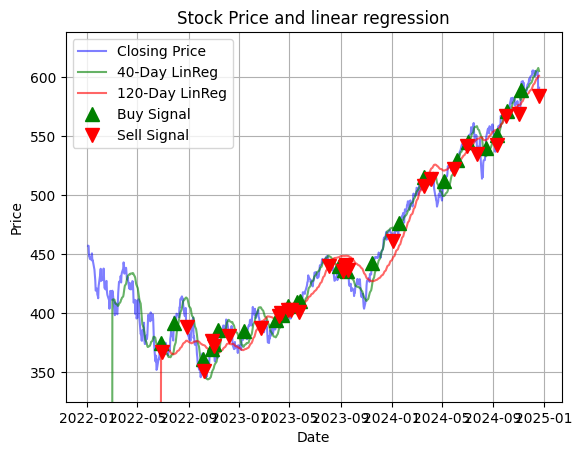

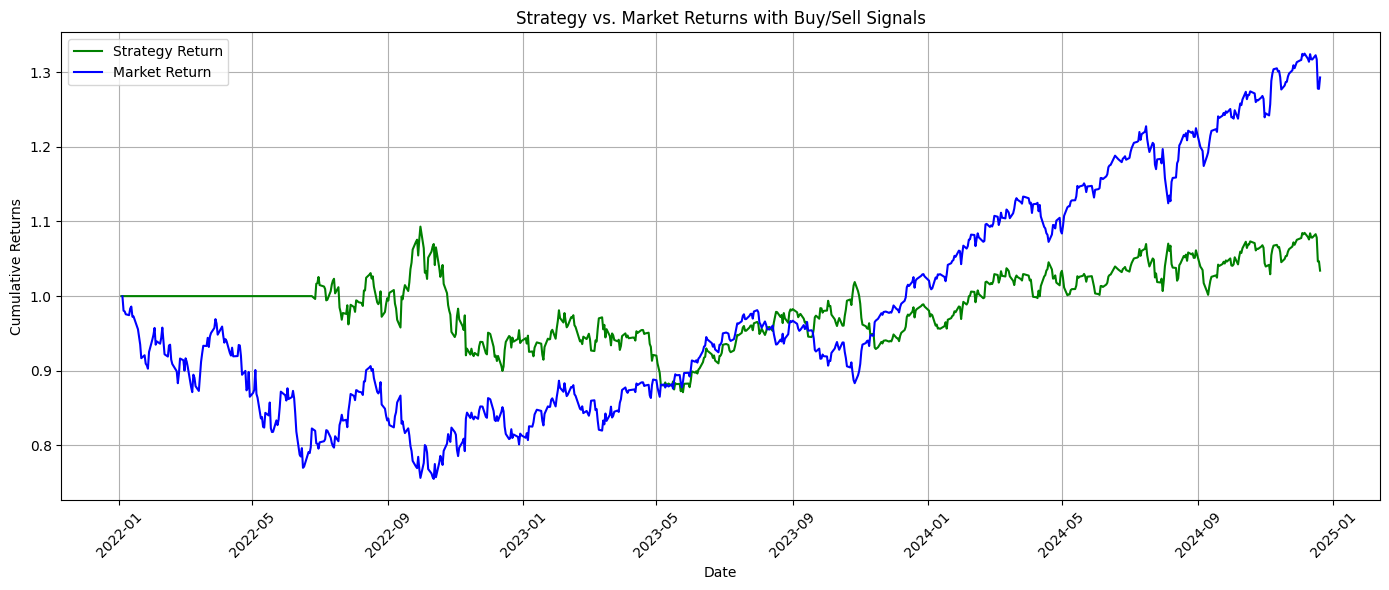

In [5]:

# Backtest the strategy

def backtest_strategy(data):
    # Calculate daily returns
    data['Daily_Return'] = data['Close'].pct_change()
    # Initialize the Strategy_Return column
    data['Strategy_Return'] = 0.0

    # Initialize variable to store the last non-zero signal (lnz)
    lnz = 0
    # Loop over the data, starting from the first row
    for i in range(1, len(data)):
        signal = data['Signal'].iloc[i]

        # If the signal is non-zero, update lnz
        if signal != 0:
            lnz = signal

        # Calculate the strategy return based on the last non-zero signal
        if lnz == 1:
            data.loc[data.index[i], 'Strategy_Return'] = data['Daily_Return'].iloc[i]
        elif lnz == -1:
            data.loc[data.index[i], 'Strategy_Return'] = -data['Daily_Return'].iloc[i]

    # Calculate the cumulative return for the strategy
    data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()

    # Calculate the cumulative return for the market (buy and hold strategy)
    data['Cumulative_Market_Return'] = (1 + data['Daily_Return']).cumprod()

    return data

data = backtest_strategy(data)
# Step 6: Visualizing the Results
# -------------------------------
# We'll plot the stock price, the two SMAs, and the buy/sell signals, as well as strategy vs. market returns.

def plot_data(data):



    # Plot the closing price
    plt.plot(data.index, data['Close'], label='Closing Price', color='blue', alpha=0.5)

    # plot the linregs
    plt.plot(data.index, data['st_linreg'], label='40-Day LinReg', color='green', alpha=0.6) # Replaced with the columns for linear regression
    plt.plot(data.index, data['lt_linreg'], label='120-Day LinReg', color='red', alpha=0.6)   # Replaced with the columns for linear regression



    # Highlight buy signals
    plt.plot(data.index[data['Signal'] == 1], data['Close'][data['Signal'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')

    # Highlight sell signals
    plt.plot(data.index[data['Signal'] == -1], data['Close'][data['Signal'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')

    # Add titles and labels
    plt.title('Stock Price and linear regression')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.ylim(325, None)


    # Show the plot
    plt.show()

# Plot the results
plot_data(data)

def plot_returns(data):
    # Plot cumulative returns for strategy and market
    plt.figure(figsize=(14, 6))
    plt.plot(data.index, data['Cumulative_Strategy_Return'], label='Strategy Return', color='green')
    plt.plot(data.index, data['Cumulative_Market_Return'], label='Market Return', color='blue')

    # Add titles and labels
    plt.title('Strategy vs. Market Returns with Buy/Sell Signals')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid()

    # Format the x-axis to show date correctly and avoid overlap
    plt.xticks(rotation=45)

    # Adjust layout to prevent clipping of labels
    plt.tight_layout()

    # Show the plot
    plt.show()

# Assuming `data` is your DataFrame with cumulative returns and signals
plot_returns(data)
# Step 7: Conclusion
# ------------------
# This code outlines a full process from loading and cleaning the stock data to implementing an SMA-based trading strategy.
# You can adjust window sizes and further tune the strategy based on additional technical indicators or combine it with other models.